#### Import and set up paths

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from skimage.io import imread
from pathlib import Path
import pandas as pd
import cv2

import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import logging
import torchvision 
from torchvision import datasets, transforms, utils
from torchsummary import summary
import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%load_ext tensorboard

In [3]:
root_directory = Path("/content/")
drive_path = root_directory / 'drive/MyDrive' / 'CS101' 

In [4]:
# Path to zip file in my drive
!unzip '/content/drive/My Drive/CS101/CS101.zip'

Streaming output truncated to the last 5000 lines.
  inflating: valset/DIC/Embryo105/t23/c2z8t23.png  
  inflating: __MACOSX/valset/DIC/Embryo105/t23/._c2z8t23.png  
  inflating: valset/DIC/Embryo105/t23/c2z12t23.png  
  inflating: __MACOSX/valset/DIC/Embryo105/t23/._c2z12t23.png  
  inflating: valset/DIC/Embryo105/t23/c2z10t23.png  
  inflating: __MACOSX/valset/DIC/Embryo105/t23/._c2z10t23.png  
  inflating: valset/DIC/Embryo105/t23/c2z7t23.png  
  inflating: __MACOSX/valset/DIC/Embryo105/t23/._c2z7t23.png  
  inflating: valset/DIC/Embryo105/t23/c2z15t23.png  
  inflating: __MACOSX/valset/DIC/Embryo105/t23/._c2z15t23.png  
  inflating: valset/DIC/Embryo105/t23/c2z9t23.png  
  inflating: __MACOSX/valset/DIC/Embryo105/t23/._c2z9t23.png  
  inflating: valset/DIC/Embryo105/t23/c2z13t23.png  
  inflating: __MACOSX/valset/DIC/Embryo105/t23/._c2z13t23.png  
  inflating: valset/DIC/Embryo105/t23/c2z11t23.png  
  inflating: __MACOSX/valset/DIC/Embryo105/t23/._c2z11t23.png  
  inflating: valset

In [8]:
if not os.path.exists("pytorch_unet.py"):
  if not os.path.exists("pytorch_unet"):
    !git clone https://github.com/usuyama/pytorch-unet.git

  %cd pytorch-unet

import pytorch_unet
%cd /content

Cloning into 'pytorch-unet'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 67 (delta 6), reused 1 (delta 0), pack-reused 55
Unpacking objects: 100% (67/67), done.
/content/pytorch-unet
/content


#### Initialize Data

In [5]:
class EmbryoDataset(Dataset):

    def __init__(self, data_dir, positive_only=False, z_stack_percentile=(0.0, 100.00), transform=None):
        self.data_dir = data_dir
        image_list_file = os.path.join(self.data_dir, 'DIC.list') 
        gt_list_file = os.path.join(self.data_dir, 'gt.list')
        gt_boundary_list_file = os.path.join(self.data_dir, 'gt_boundary.list')

        with open(image_list_file, 'r') as f:
            self.image_list = f.read().splitlines()
        with open(gt_list_file, 'r') as f:
            self.gt_list = f.read().splitlines()
        with open(gt_boundary_list_file, 'r') as f:
            self.gt_boundary_list = f.read().splitlines()

        onset_df = pd.read_excel(drive_path / 'Time_Annotation.xlsx')
        self.onset_dict = dict(zip(onset_df["embryo_index"].astype(int), onset_df["onset"].astype(int)))
        self.z_dict = dict(zip(onset_df["embryo_index"].astype(int), onset_df["z_num"].astype(int)))

        if positive_only:
            pruned_image_list = []
            pruned_gt_list = []
            pruned_gt_boundary_list = []
            
            for index, gt_path in enumerate(self.gt_list):
                embryo_details = gt_path.split('/')
                embryo_num = int(embryo_details[-3][6:])
                timestep = int(embryo_details[-2][1:])
                if timestep >= self.onset_dict[embryo_num]:
                    z_num = int(embryo_details[-1].split('z')[1].split('t')[0])
                    z_percentile = z_num * 100 / self.z_dict[embryo_num]
                    if z_percentile >= z_stack_percentile[0] and z_percentile <= z_stack_percentile[1]:
                        pruned_image_list.append(self.image_list[index])
                        pruned_gt_list.append(self.gt_list[index])
                        pruned_gt_boundary_list.append(self.gt_boundary_list[index])


            self.image_list = pruned_image_list
            self.gt_list = pruned_gt_list
            self.gt_boundary_list = pruned_gt_boundary_list

        self.data_dir = data_dir
        self.length = len(self.image_list)
        self.transform = transform

    def __getitem__(self, index):
        image_path = os.path.join(self.data_dir, self.image_list[index]) 
        gt_path = os.path.join(self.data_dir, self.gt_list[index])
        gt_boundary_path = os.path.join(self.data_dir, self.gt_boundary_list[index])
        
        image = imread(image_path, as_gray=True)
        gt = imread(gt_path, as_gray=True)
        gt_boundary = imread(gt_boundary_path, as_gray=True)
        image = self.image_transform(image)
        gt = self.gt_transform(gt)
        gt_boundary = self.boundary_transform(gt_boundary)

        # Extract embryo image details
        embryo_details = gt_path.split('/')
        embryo_num = int(embryo_details[-3][6:])
        timestep = int(embryo_details[-2][1:])
        z_num = int(embryo_details[-1].split('z')[1].split('t')[0])
        z_percentile = z_num * 100 / self.z_dict[embryo_num]
        onset = self.onset_dict[embryo_num]

        tags = {"embryo_num": embryo_num, "timestep": timestep, "z_num": z_num, "z_percentile": z_percentile, "onset": onset}
        return image, gt, gt_boundary, tags

    def __len__(self):
        return self.length

    def image_transform(self, image):
        trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.4111], [0.2077])])
        return trans(image)

    def gt_transform(self, gt):
        gt = gt / 255.0
        trans = transforms.ToTensor()
        return trans(gt)

    def boundary_transform(self, gt_boundary):
        gt_boundary = gt_boundary / 255.0
        trans = transforms.ToTensor()
        return trans(gt_boundary)

In [14]:
# Instantiate train, validation, and test dataloaders
train_set = EmbryoDataset(root_directory / 'trainset', positive_only = True)
test_set = EmbryoDataset(root_directory / 'testset', positive_only = True)
val_set = EmbryoDataset(root_directory / 'valset', positive_only = True)

batch_size = 4

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
train_loader_not_shuffled = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

dataloaders = {"train": train_loader, "test": test_loader, "val": val_loader}

#### Training helper functions

In [18]:
%cd pytorch-unet
from loss import dice_loss
%cd /content
from collections import defaultdict
import torch.nn.functional as F

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def get_original_fl(embryo_num, timestep, z_num):
    fl_image_path_parent = drive_path / 'CS101_data' / 'embryo89-8_cell_stage-fluo_z_stack'
    for i in range(1,4):
        embryo_path = "Embryo{}/t{}/c{}z{}t{}.png".format(embryo_num, timestep, i, z_num, timestep)
        fl_image_path = fl_image_path_parent / embryo_path
        if fl_image_path.is_file():
            fl_image = imread(fl_image_path, as_gray=True)
            return fl_image

def calculate_pixel_metrics(pred, label):
    '''
    Calculate TP, FP, FN of one image
    '''
    TP = (pred * label).sum()    
    FP = ((1-label) * pred).sum()
    FN = (label * (1-pred)).sum()

    return TP.item(), FP.item(), FN.item()

def get_samples_for_viz(val_metrics, N, thresh):
    '''
    Find images with best/worst/median iou at the given thresh
    '''
    all_imgs_by_iou = []
    for batch in val_metrics:
        imgs = val_metrics[batch][thresh]
        for pos in imgs:
            info = imgs[pos]
            bound_iou = info["iou"]
            all_imgs_by_iou.append((bound_iou, batch, pos, info))
    
    # Sort by lowest to highest
    all_imgs_by_iou.sort(key=lambda x: x[0])
    best_ious = all_imgs_by_iou[-N:]
    worst_ious = all_imgs_by_iou[:N]

    # computing strt, and end index for middle N
    strt_idx = (len(all_imgs_by_iou) // 2) - (N // 2)
    end_idx = (len(all_imgs_by_iou) // 2) + (N // 2)
    
    # slicing extracting middle elements
    middle_ious = all_imgs_by_iou[strt_idx: end_idx]

    return best_ious, middle_ious, worst_ious

def show_img_sample(axs, batch, inputs, labels, boundaries, tags, model, ious, subplot_row, thresh):
    for bound_iou, img_batch, pos, _ in ious:
        if batch == img_batch:
            inputs = inputs.to(device)
            labels = labels.to(device)
            boundaries = boundaries.to(device)

            embryo_num = tags["embryo_num"][pos]
            timestep = tags["timestep"][pos]
            z_num = tags["z_num"][pos]
            onset = tags["onset"][pos]
            z_percentile = tags["z_percentile"][pos]
            orig_fl = get_original_fl(embryo_num, timestep, z_num)

            preds_prob = model(inputs)
            preds = torch.where(preds_prob > thresh, 1.0, 0.0).int()

            axs[subplot_row, 0].set_title("DIC")
            axs[subplot_row, 0].imshow(inputs[pos].cpu().numpy()[0], cmap="gray")
            axs[subplot_row, 1].set_title("FL")
            axs[subplot_row, 1].imshow(orig_fl, cmap="gray")
            axs[subplot_row, 2].set_title("GT")
            axs[subplot_row, 2].imshow(labels[pos].cpu().numpy()[0], cmap="gray")
            axs[subplot_row, 3].set_title("Boundary")
            axs[subplot_row, 3].imshow(boundaries[pos].cpu().numpy()[0], cmap="gray")
            axs[subplot_row, 4].set_title("IOU: {}".format(bound_iou))
            axs[subplot_row, 4].imshow((preds[pos] * boundaries[pos]).cpu().numpy()[0], cmap="gray")
            
            preds_prob = (preds_prob[pos].detach() * boundaries[pos]).cpu().numpy()[0]
            l1_distance = np.mean(np.abs(labels[pos].cpu().numpy()[0] - preds_prob))

            axs[subplot_row, 5].set_title("L1 Distance: {}".format(l1_distance))
            axs[subplot_row, 5].imshow(preds_prob, cmap="gray")
            #embryo_info_text = "Embryo {}\n Timestep {}\n Onset {}\n z_percentile {}".format(embryo_num, timestep, onset, z_percentile)
            #axs[subplot_row, 5].text(0.5, 0.5, embryo_info_text, horizontalalignment='center', verticalalignment='center')

            subplot_row += 1
    return subplot_row

def visualize_val_metrics(model, val_loader, val_metrics, N=2, non_boundary_metrics=False):
    '''
    Takes data in val_metrics and displays:
        PR Curve
        Iou vs threshold
        Images with highest iou
        Images with lowest iou
        Images with median iou
    '''

    # Compute PR curve and IoU scores
    threshs = np.linspace(0, 1, num=101) # Set of thresholds to try
    bound_precisions = np.zeros_like(threshs)
    bound_recalls = np.zeros_like(threshs)

    # Checks all thresholds and finda threshold that corresponds to best iou
    max_threshold = 0
    max_bound_iou = 0
    curr_bound_iou = 0
    num_images = len(val_loader) * batch_size
    iou_per_thresh = []
    for i in range(len(threshs)):
        thresh = threshs[i]
        for batch in val_metrics:
            thresh_dict = val_metrics[batch][thresh]
            for pos in thresh_dict:
                curr_bound_iou += thresh_dict[pos]['iou']
                bound_precisions[i] += thresh_dict[pos]['precision']
                bound_recalls[i] += thresh_dict[pos]['recall']
        iou_per_thresh.append(curr_bound_iou / num_images)
        if curr_bound_iou > max_bound_iou:
            max_bound_iou = curr_bound_iou
            max_threshold = thresh
        curr_bound_iou = 0
    
    max_bound_iou /= num_images
    bound_precisions /= num_images
    bound_recalls /= num_images

    print("\n###")
    print("Mean Boundary IoU at threshold {}: {}".format(max_threshold, max_bound_iou))


    # Get samples with best, middle, and worst ious
    best_ious, middle_ious, worst_ious = get_samples_for_viz(val_metrics, N, max_threshold)

    fig, axs = plt.subplots(7, 6, figsize=(35, 35))
    
    if non_boundary_metrics:
        axs[0,0].set_title("Image PR Curve")
        axs[0,0].set_xlabel("Recall")
        axs[0,0].set_ylabel("Precision")
        axs[0,0].set_xlim([0,1])
        axs[0,0].set_ylim([0,1])
        axs[0,0].plot(img_recalls, img_precisions)

    axs[0,1].set_title("Boundary PR Curve")
    axs[0,1].set_xlabel("Recall")
    axs[0,1].set_ylabel("Precision")
    axs[0,1].set_xlim([0,1])
    axs[0,1].set_ylim([0,1])
    axs[0,1].plot(bound_recalls, bound_precisions)

    axs[0,2].set_title("IoU vs Threshold")
    axs[0,2].set_xlabel("Threshold")
    axs[0,2].set_ylabel("IoU")
    axs[0,2].set_xlim([0,1])
    axs[0,2].set_ylim([0,1])
    axs[0,2].plot(threshs, iou_per_thresh)

    subplot_row = 1
    dataloader_iterator = iter(val_loader)
    for batch in range(len(val_loader)):
        inputs, labels, boundaries, tags = next(dataloader_iterator)
        subplot_row = show_img_sample(axs, batch, inputs, labels, boundaries, tags, model, best_ious, subplot_row, max_threshold)
        subplot_row = show_img_sample(axs, batch, inputs, labels, boundaries, tags, model, middle_ious, subplot_row, max_threshold)
        subplot_row = show_img_sample(axs, batch, inputs, labels, boundaries, tags, model, worst_ious, subplot_row, max_threshold)
    plt.show()

def populate_val_metrics(inputs, labels, boundaries, preds_prob, batch_num, val_metrics, non_boundary_metrics=False):
    '''
    ASSUMES VAL_LOADER IS NOT SHUFFLED
    Takes in batch and adds to the validation metrics
    val_metrics layout {
        batch_num: {
            thresh: {
                pos: {
                    TP:
                    FP:
                    FN:
                    iou:
                    precision:
                    recall:
                }
            }
        }
    }
    '''
    threshs = np.linspace(0, 1, num=101) # Set of thresholds to try
    SMOOTH = 1e-6
    batch_dict = {}

    # Force model to predict black outside of boundary
    preds_prob = preds_prob * boundaries
    for i, thresh in enumerate(threshs):
        preds = torch.where(preds_prob > thresh, 1.0, 0.0).int()
        thresh_dict = {}
        for pos in range(labels.shape[0]):
            pos_dict = {}

            bound_mask = (boundaries[pos] > 0)
            bound_pred_prob = torch.masked_select(preds_prob[pos], bound_mask)
            bound_pred = torch.masked_select(preds[pos], bound_mask)
            bound_label = torch.masked_select(labels[pos], bound_mask)

            bound_TP, bound_FP, bound_FN = calculate_pixel_metrics(bound_pred, bound_label)
            bound_precision = (bound_TP+SMOOTH) / (bound_TP+bound_FP+SMOOTH)
            bound_recall = (bound_TP+SMOOTH) / (bound_TP+bound_FN+SMOOTH)
            bound_iou = (bound_TP+SMOOTH) / (bound_TP+bound_FP+bound_FN+SMOOTH)

            pos_dict['TP'] = bound_TP
            pos_dict['FP'] = bound_FP
            pos_dict['FN'] = bound_FN
            pos_dict['iou'] = bound_iou
            pos_dict['precision'] = bound_precision
            pos_dict['recall'] = bound_recall
            #pos_dict['l1'] = torch.mean(torch.abs(torch.sub(bound_pred_prob, bound_label)))
            thresh_dict[pos] = pos_dict
        batch_dict[thresh] = thresh_dict
    val_metrics[batch_num] = batch_dict

/content/pytorch-unet
/content


#### Declare Model and Training loop

In [10]:
import torch.nn as nn
import torchvision.models
from collections import OrderedDict

class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        logits = self.conv(dec1)
        return torch.sigmoid(logits)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [11]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return torch.sum(F_loss)

def calc_loss(pred, target, boundary, metrics, bce_weight=0.5):
    mask = (boundary > 0)
    pred = torch.masked_select(pred, mask).float()
    target = torch.masked_select(target, mask).float()
    
    focal = FocalLoss(logits=False, reduce=False)
    loss = focal.forward(pred, target)
    metrics['loss'] += loss.data.cpu().numpy()

    return loss

def train_model(model, optimizer, scheduler, checkpoint_path, num_epochs=25):
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        epoch_loss_full = defaultdict(float)
        epoch_loss_dice = defaultdict(float)
        epoch_loss_bce = defaultdict(float)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            batch_num = -1

            if phase == "val":
                val_metrics = {}

            for inputs, labels, boundaries, _ in tqdm(dataloaders[phase]):
                batch_num += 1
                inputs = inputs.to(device)
                labels = labels.to(device)
                boundaries = boundaries.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, boundaries, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)
                iteration = epoch_samples // inputs.size(0)

                if phase == "val":
                    populate_val_metrics(inputs, labels, boundaries, outputs, batch_num, val_metrics)
                    
                if iteration % 200 == 1 and phase == 'train':
                    #torch.save(model.state_dict(), os.path.join(checkpoint_path, '{}_{}.pth'.format(epoch, iteration)))
                    print_metrics(metrics, epoch_samples, phase)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'train':
                # Update the learning rate
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                
                # Log training loss
                epoch_loss_full['train'] = metrics['loss'] / epoch_samples
                # epoch_loss_bce['train'] = metrics['bce'] / epoch_samples
                # epoch_loss_dice['train'] = metrics['dice'] / epoch_samples

            if phase == "val":
                # Log validation loss
                epoch_loss_full['val'] = metrics['loss'] / epoch_samples
                # epoch_loss_bce['val'] = metrics['bce'] / epoch_samples
                # epoch_loss_dice['val'] = metrics['dice'] / epoch_samples

                # Visualize model results
                print("Epoch {}: Validation visualizations".format(epoch))
                visualize_val_metrics(model, dataloaders[phase], val_metrics)


            if phase == 'val':
                if epoch_loss < best_loss:
                    # save the model weights
                    print(f"saving best model to {checkpoint_path}")
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), os.path.join(checkpoint_path, 'best_{}.pth'.format(epoch)))
                else:
                    torch.save(model.state_dict(), os.path.join(checkpoint_path, '{}.pth'.format(epoch)))
        
        # Plot Loss
        writer.add_scalars('Loss', epoch_loss_full, epoch)
        # writer.add_scalars('BCE Loss', epoch_loss_bce, epoch)
        # writer.add_scalars('Dice Loss', epoch_loss_dice, epoch)


        #torch.save(model.state_dict(), os.path.join(checkpoint_path, '{}.pth'.format(epoch)))
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val loss: {:4f}'.format(best_loss))

#### Load Model

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

model = UNet().to(device)
# summary(model, input_size=(1, 512, 512), batch_size=batch_size)

device cuda


In [13]:
# Run if you want to load model from checkpoint

model_path = drive_path / 'exps' / 'anish' / 'exp12' / 'checkpoints' / 'dic_slice.pth'#'best_1.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

#### Train Model

In [ ]:
log_path = drive_path / 'exps' / 'anish' / 'exp12' / 'logs'
checkpoint_path = drive_path / 'exps' / 'anish' / 'exp12' / 'checkpoints'
writer = SummaryWriter(log_path)

optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
train_model(model, optimizer_ft, exp_lr_scheduler, checkpoint_path, num_epochs=25)

In [ ]:
writer.flush()
writer.close()
%tensorboard --logdir='/content/drive/MyDrive/CS101/exps/anish/exp12/logs'

#### Evaluate performance on validation set

In [16]:
val_metrics = {}
model.eval()
batch_num = -1
for inputs, labels, boundaries, _ in tqdm(val_loader):
    batch_num += 1
    inputs = inputs.to(device)
    labels = labels.to(device)
    boundaries = boundaries.to(device)
    outputs = model(inputs)
    populate_val_metrics(inputs, labels, boundaries, outputs, batch_num, val_metrics)

100%|██████████| 176/176 [01:00<00:00,  2.93it/s]



###
Mean Boundary IoU at threshold 0.3: 0.20607721014026384


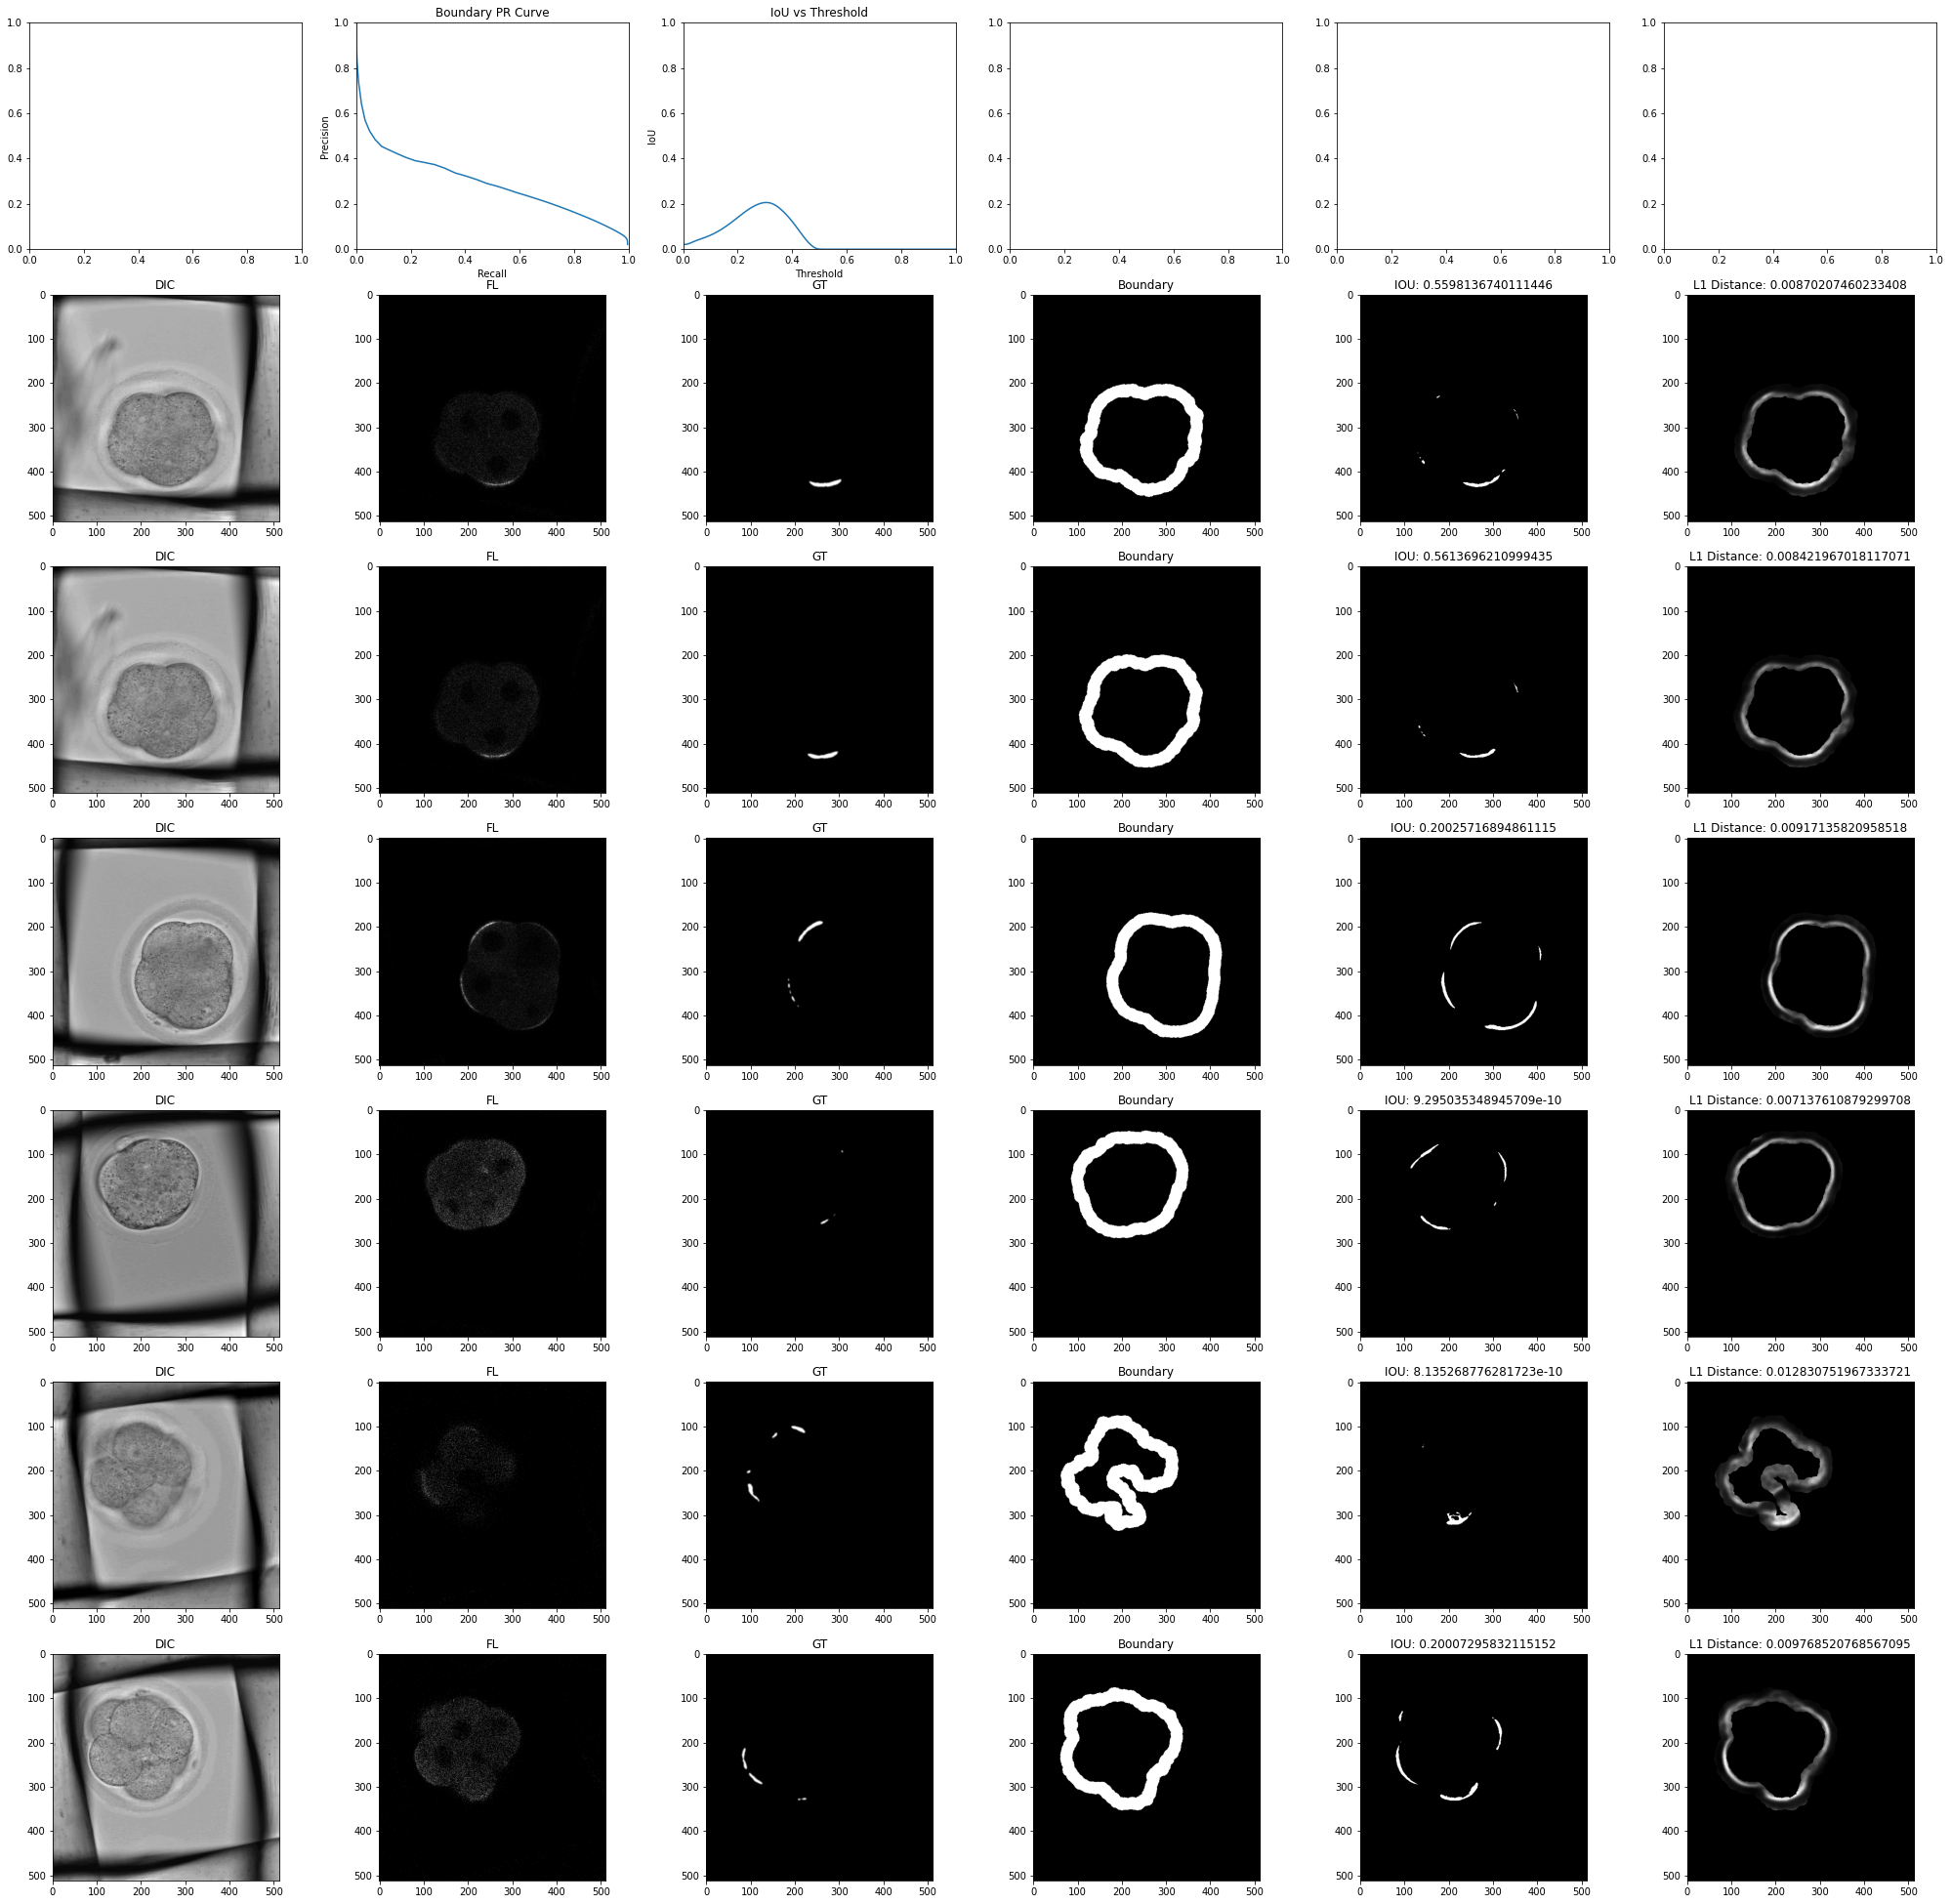

In [19]:
visualize_val_metrics(model, val_loader, val_metrics)

#### Evaluate performance on train set

In [20]:
train_metrics = {}
model.eval()
batch_num = -1
for inputs, labels, boundaries, _ in tqdm(train_loader_not_shuffled):
    batch_num += 1
    inputs = inputs.to(device)
    labels = labels.to(device)
    boundaries = boundaries.to(device)
    outputs = model(inputs)
    populate_val_metrics(inputs, labels, boundaries, outputs, batch_num, train_metrics)

100%|██████████| 2048/2048 [11:49<00:00,  2.89it/s]



###
Mean Boundary IoU at threshold 0.32: 0.18827046828394123


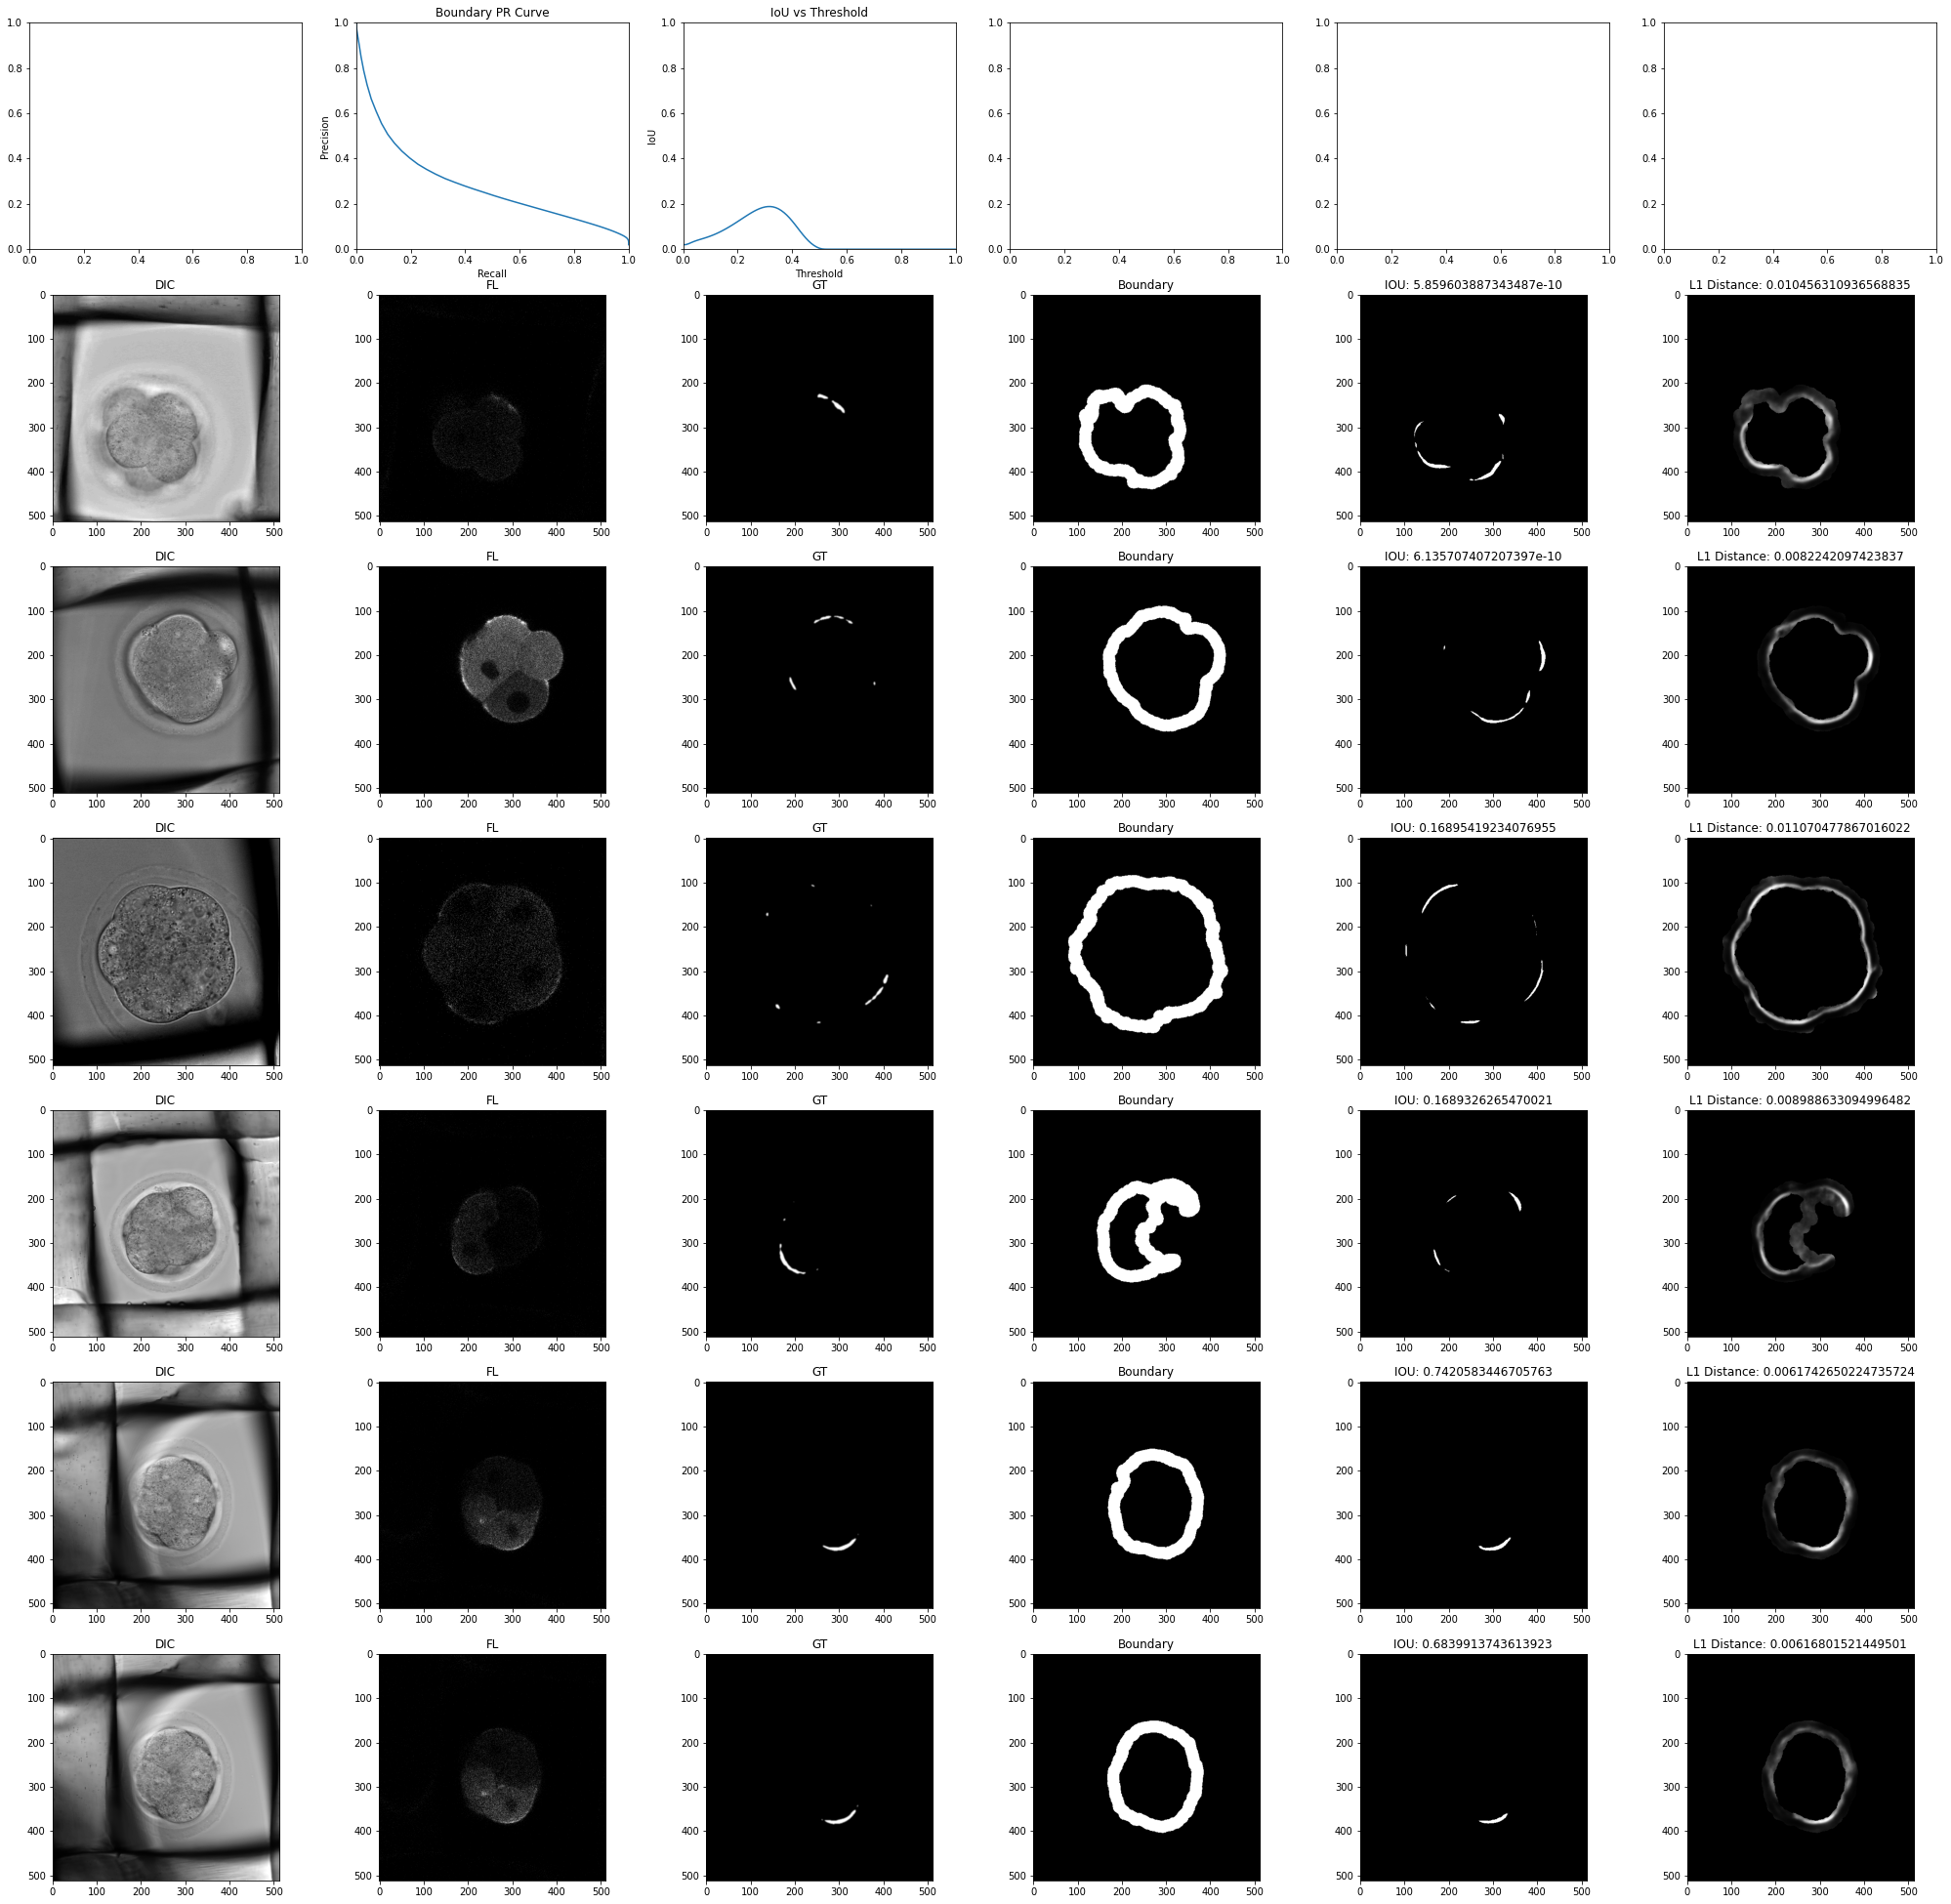

In [22]:
visualize_val_metrics(model, train_loader_not_shuffled, val_metrics)